# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


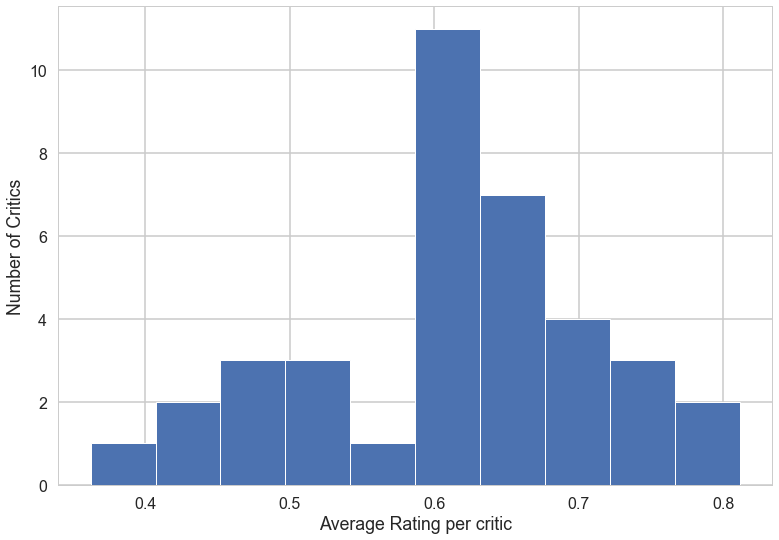

In [5]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

In [6]:
print("Mean rating:",np.mean(means[counts > 100]))
print("Median rating:",np.median(means[counts > 100]))

Mean rating: 0.6123994405433357
Median rating: 0.615894039735


<i>The average rating per critic is around 0.61 (1 for "fresh", 0 for "rotten"). With a median rating around 0.62, a typical movie critic will more likely rate a movie as "fresh" than "rotten".</i>
<p>
<i>Regarding the shape of the distribution, it is skewed more towards the "fresh" side. There is some intuitive sense in this, as we are limiting the reviews to those from critics who regularly review movies (greater than 100 reviews). This makes it much less likely for lower quality critics to appear in this analysis, who may target certain movies as "rotten".</i>

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [8]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [9]:
#your turn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report

clf = MultinomialNB()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Training accuracy score:",clf.score(X_train,y_train))
print("Test accuracy score:",clf.score(X_test,y_test))
print(classification_report(y_test,clf.predict(X_test)))

Training accuracy score: 0.922144693353
Test accuracy score: 0.75840651103
             precision    recall  f1-score   support

          0       0.74      0.61      0.67      1860
          1       0.77      0.86      0.81      2809

avg / total       0.76      0.76      0.75      4669



<i>The test score is quite a bit lower than the training data score. Having said that, at an accuracy of 75.8%, it can be considered a "good" classifier.</i>

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

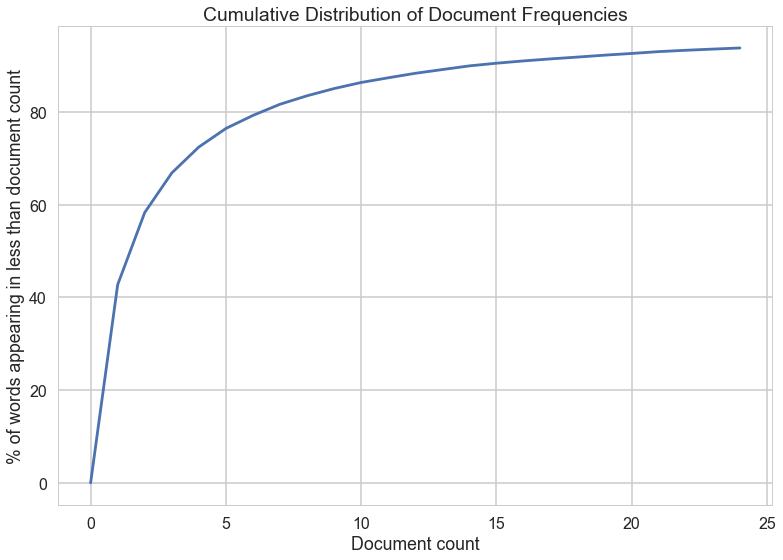

In [10]:
# Your turn.
vect = CountVectorizer(min_df=0)

X = vect.fit_transform(critics.quote)
X = X.tocsc()

# getting the number of documents that contains a particular word
# by counting non-zero values per column (word)
doc_count = X.getnnz(0)

x_plt = np.arange(0,25)
y_plt = np.empty(25)

# use np.mean function to get percentage of "True" values
for i in range(len(x_plt)):
    y_plt[i] = np.mean(doc_count <= i) * 100

plt.plot(x_plt,y_plt)
plt.xlabel("Document count")
plt.ylabel("% of words appearing in less than document count")
plt.title("Cumulative Distribution of Document Frequencies")


<i>Observing the above chart, it appears that an appropriate value for min_df would be 3, while max_df should be around 10.</i>

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [11]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [12]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [13]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

<i>The function `log_likelihood` uses the logarithmic probability rather than straight probability. This is used to further penalize probabilities that approach 0 (as the probability goes towards 0, the logarithmic value approaches negative infinity).</i>
<p>
<i>If $\alpha$ is too high, the accuracy score will decrease significantly.</i>

In [198]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 3 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    
    clf = MultinomialNB(alpha=alpha)
    score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)

    if score > maxscore:
        maxscore = score
        best_alpha = alpha    

In [196]:
print("alpha: {}".format(best_alpha))

alpha: 1


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [199]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.931249
Accuracy on test data:     0.741094


In [16]:
from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(ytest, clf.predict(xtest)))
print('f1 score:', f1_score(ytest,clf.predict(xtest)))

[[1940 2319]
 [ 648 5985]]
f1 score: 0.801365736092


<i>It appears that this classifier is not quite as accurate as the earlier example.</i>

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [17]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
             delight 0.95
                trek 0.95
             western 0.95
                fear 0.94
          delightful 0.94
        accomplished 0.94
           tradition 0.94
            haunting 0.94
           energetic 0.94
             popular 0.94
Bad words	     P(fresh | word)
        unsatisfying 0.12
             suffers 0.11
             witless 0.11
             tedious 0.11
      disappointment 0.09
       disappointing 0.09
                lame 0.08
               awful 0.07
               bland 0.06
             problem 0.05


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

<i>The above method works in identifying whether the review for a movie is "fresh" or "rotten" because a higher probability represents a higher chance that the movie was reviewed as "fresh" based on the presence of such word.</i>

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [18]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
The plot of The Glimmer Man involves not only the Family Man but Our Evil Secret Government, the Russian Mafia and Rich Powerful Politicians -- the three stooges of action cinema in the '90s.

Like other Irvin films, this noir saga (more of an urban Western) is burdened with a philosophical layer that's incongruous with the basic tale, though acting by Keitel, Dorff, and others is good.

Herzog offers some evidence of Kinski's great human warmth, somewhat more of his rage of unimaginable proportions, and a good demonstration of Kinski's uncanny capacity to corkscrew his way into the frame.

Possibilities for a dark, child's view fantasy set in rural America of yore are visible throughout the $20 million production but various elements have not entirely congealed into a unified achievement.

Handsome, but curiously cold, considering the emotional heat of Anglo-Irish matters. Fortunately, Liam Neeson commands almost every frame.

Mi

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [19]:
#your turn

text_test = ['This movie is not remarkable, touching, or superb in any way']
X_own = vectorizer.transform(text_test)

clf.predict_proba(X_own)


array([[ 0.00102144,  0.99897856]])

<i>The above result indicates that the above text is predicted to be more "fresh", in fact overly so. As we can see with the context of the words (such as "not"), this is not really the case. The vectorizer does not take the negation of such positive words into proper account when making such freshness prediction.</i>

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [20]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

In [21]:
print(len(Xtfidf.getnnz(1)))

#words = np.array(tfidfvectorizer.get_feature_names())

#print(Xtfidf)


15561


<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

In [22]:
# Your turn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import f1_score

X = critics.quote
y = (critics.fresh == 'fresh').values.astype(np.int)

X2train,X2test,y2train,y2test = train_test_split(X,y,test_size=0.3)
print(X2train.shape,X2test.shape,y2train.shape,y2test.shape)

<h3>Naive Bayes with N-grams</h3>

In [140]:
# use N-grams
pipeline_ng = Pipeline([('vect',CountVectorizer(stop_words='english')),
                        ('clf', MultinomialNB())])

parameters_ng = {
    'vect__min_df': (1,2,3),
    'vect__max_df': (0.25,0.50,0.75),
    'vect__ngram_range': ((1,1),(1,2),(1,3)),
    'clf__alpha': (0.01,0.1,1,10),
}

In [146]:
grid_search_ng = GridSearchCV(pipeline_ng, parameters_ng, n_jobs=-1, verbose=1,cv=5)
grid_search_ng.fit(X2train,y2train)
print(grid_search_ng.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  4.6min finished


{'clf__alpha': 1, 'vect__max_df': 0.25, 'vect__min_df': 3, 'vect__ngram_range': (1, 1)}


In [171]:
cv_results_ng = pd.DataFrame(grid_search_ng.cv_results_)
cv_results_ng[cv_results_ng['rank_test_score']==1]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__alpha,param_vect__max_df,param_vect__min_df,param_vect__ngram_range,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
60,0.479051,0.106786,0.757437,0.882459,1,0.25,3,"(1, 1)","{'clf__alpha': 1, 'vect__max_df': 0.25, 'vect_...",1,0.76055,0.877181,0.769513,0.880652,0.768595,0.883636,0.76079,0.885816,0.727732,0.885013,0.059944,0.027821,0.01532,0.003172
69,0.610531,0.121300,0.757437,0.882459,1,0.5,3,"(1, 1)","{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__...",1,0.76055,0.877181,0.769513,0.880652,0.768595,0.883636,0.76079,0.885816,0.727732,0.885013,0.074255,0.040480,0.01532,0.003172
78,0.409070,0.094865,0.757437,0.882459,1,0.75,3,"(1, 1)","{'clf__alpha': 1, 'vect__max_df': 0.75, 'vect_...",1,0.76055,0.877181,0.769513,0.880652,0.768595,0.883636,0.76079,0.885816,0.727732,0.885013,0.025792,0.017477,0.01532,0.003172


<i>Using <b>GridSearchCV</b>, in this circumstance, the best parameters indicates that single words is still better than any n-grams.</i>

In [173]:
pipeline_ng.set_params(vect__min_df=2,vect__max_df=0.25,vect__ngram_range=(1,1),clf__alpha=1)
pipeline_ng.fit(X2train,y2train)

print('accuracy score:',pipeline_ng.score(X2test,y2test))
print('f1 score:', f1_score(y2test,pipeline_ng.predict(X2test)))

accuracy score: 0.755836367531
f1 score: 0.807821982468


<i>Applying the best parameters using cross-validated grid search, we can achieve a very respectable accuracy score of 75.6%.</i>

<h3>Random Forest Classifier</h3>

In [80]:
from sklearn.ensemble import RandomForestClassifier
pipeline_rf = Pipeline([('vect2', CountVectorizer()),
                        ('clf',RandomForestClassifier())])

parameters_rf = {
    'vect2__min_df': (2,3),
    'vect2__max_df': ([0.25]),
    'vect2__ngram_range': [(1,1)],
    'clf__n_estimators': (500,1000,2000),
    'clf__max_features': ["log2"],
}

grid_search = GridSearchCV(pipeline_rf, parameters_rf, n_jobs=2, verbose=1, cv=5)
grid_search.fit(X2train,y2train)
print(grid_search.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 20.9min finished


{'clf__max_features': 'log2', 'clf__n_estimators': 2000, 'vect2__max_df': 0.25, 'vect2__min_df': 3, 'vect2__ngram_range': (1, 1)}


In [81]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.749632757988
{'clf__max_features': 'log2', 'clf__n_estimators': 2000, 'vect2__max_df': 0.25, 'vect2__min_df': 3, 'vect2__ngram_range': (1, 1)}


In [82]:
# set parameters and fit
pipeline_rf.set_params(clf__max_features="log2",clf__n_estimators=2000,vect2__min_df=3,vect2__max_df=0.25,vect2__ngram_range=(1,1),clf__n_jobs=2)
pipeline_rf.fit(X2train,y2train)


Pipeline(steps=[('vect2', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        str...ators=2000, n_jobs=2, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])

In [84]:
print("Random Forest Classifier Training Score:",pipeline_rf.score(X2train,y2train))
print("Random Forest Classifier Test Score:",pipeline_rf.score(X2test,y2test))

Random Forest Classifier Training Score: 0.999632757988
Random Forest Classifier Test Score: 0.741700578282


In [78]:
f1_score(y2test,pipeline_rf.predict(X2test))

0.80593680178742422

<i>By utilizing GridSearchCV and modifying the <b>n_estimators</b> hyperparameter, it is possible to get accuracy close to that of a naive Bayes algorithm. However, the computational cost is significantly higher for such marginal improvement in accuracy.</i>

<h3>TF-IDF</h3>

In [206]:
pipeline_tf = Pipeline([('vect',TfidfVectorizer(stop_words='english')),
                        ('clf', MultinomialNB())])

parameters_tf = {'vect__min_df': (2,3,4),
                 'vect__max_df': (0.25,0.50,0.75),
                 'vect__ngram_range': ((1,1),(1,2),(1,3)),
                 'clf__alpha': (0.01,0.1,1,10)}

grid_search_tf = GridSearchCV(pipeline_tf, parameters_tf, n_jobs=-1, verbose=1,cv=5)
grid_search_tf.fit(X2train,y2train)
print(grid_search_tf.best_params_)
print(grid_search_tf.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  4.2min finished


{'clf__alpha': 0.1, 'vect__max_df': 0.25, 'vect__min_df': 3, 'vect__ngram_range': (1, 1)}
0.750367242012


In [207]:
cv_results_tf = pd.DataFrame(grid_search_tf.cv_results_)
cv_results_tf[cv_results_tf['rank_test_score']==1]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__alpha,param_vect__max_df,param_vect__min_df,param_vect__ngram_range,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
30,0.429401,0.093079,0.750367,0.894487,0.1,0.25,3,"(1, 1)","{'clf__alpha': 0.1, 'vect__max_df': 0.25, 'vec...",1,0.75367,0.889578,0.766299,0.895341,0.754362,0.894997,0.751607,0.893964,0.725895,0.898554,0.012474,0.005027,0.013274,0.002895
39,0.443865,0.089927,0.750367,0.894487,0.1,0.5,3,"(1, 1)","{'clf__alpha': 0.1, 'vect__max_df': 0.5, 'vect...",1,0.75367,0.889578,0.766299,0.895341,0.754362,0.894997,0.751607,0.893964,0.725895,0.898554,0.029330,0.005591,0.013274,0.002895
48,0.429302,0.086353,0.750367,0.894487,0.1,0.75,3,"(1, 1)","{'clf__alpha': 0.1, 'vect__max_df': 0.75, 'vec...",1,0.75367,0.889578,0.766299,0.895341,0.754362,0.894997,0.751607,0.893964,0.725895,0.898554,0.010148,0.001666,0.013274,0.002895


In [208]:
pipeline_tf.set_params(vect__min_df=3,vect__max_df=0.25,vect__ngram_range=(1,1),clf__alpha=0.1)
pipeline_tf.fit(X2train,y2train)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

In [209]:
print("TF-IDF vectorizer training score:",pipeline_tf.score(X2train,y2train))
print("TF-IDF vectorizer test score:",pipeline_tf.score(X2test,y2test))


TF-IDF vectorizer training score: 0.891112743298
TF-IDF vectorizer test score: 0.744484900407


<i>The naive Bayes classier, with the <b>TF-IDF vectorizer</b>, is not quite as good as CountVectorizer. Nevertheless, it is computationally quicker than the Random Forest Classifier.</i>

<h3>Support Vector Machine (SVM)</h3>

In [123]:
from sklearn.linear_model import SGDClassifier


pipeline_svm = Pipeline([('vect', TfidfVectorizer()),
                         ('clf', SGDClassifier(loss='modified_huber', penalty='l2',
                                              random_state=42, #max_iter=5,tol=None
                                              ))])
parameters_svm = {
    'vect__min_df': (2,3),
    'vect__max_df': (0.25,0.50),
    'vect__ngram_range': ((1,1),(1,2),(1,3)),
    'clf__alpha': (0.001,0.01,0.1,1),
}

grid_search_svm = GridSearchCV(pipeline_svm,parameters_svm, n_jobs=-1, verbose=1,cv=5)
grid_search_svm.fit(X2train,y2train)
print(grid_search_svm.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  6.0min finished


{'clf__alpha': 0.001, 'vect__max_df': 0.25, 'vect__min_df': 2, 'vect__ngram_range': (1, 1)}


In [210]:
cv_results_svm = pd.DataFrame(grid_search_svm.cv_results_)
cv_results_svm[cv_results_svm['rank_test_score']==1]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__alpha,param_vect__max_df,param_vect__min_df,param_vect__ngram_range,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,0.449760,0.086901,0.758814,0.883882,0.001,0.25,2,"(1, 1)","{'clf__alpha': 0.001, 'vect__max_df': 0.25, 'v...",1,0.766055,0.880051,0.774564,0.881226,0.746556,0.887078,0.758035,0.883062,0.748852,0.887996,0.032286,0.005069,0.010493,0.003148
12,0.484443,0.097356,0.758814,0.882046,0.001,0.5,2,"(1, 1)","{'clf__alpha': 0.001, 'vect__max_df': 0.5, 've...",1,0.766055,0.880280,0.775023,0.882029,0.748393,0.885013,0.753903,0.879849,0.750689,0.883062,0.037549,0.004628,0.010138,0.001886


In [212]:
pipeline_svm.set_params(clf__alpha=0.001,vect__max_df=0.25,vect__min_df=2,vect__ngram_range=(1,1))
pipeline_svm.fit(X2train,y2train)
print(pipeline_svm.score(X2test,y2test))

0.752409509531


<i>Using <b>Support Vector Machines</b>, it is possible to achieve performance similar or better than naive Bayes.</i>

In [216]:
from sklearn.decomposition import LatentDirichletAllocation

pipeline_lda = Pipeline([('vect4', CountVectorizer(stop_words='english')),
                         ('lda', LatentDirichletAllocation(n_topics=10,max_iter=5,learning_method='online',learning_offset=50.)),
                         ('clf', MultinomialNB())
                        ])

parameters_lda = {
    'vect4__min_df': (1,2,3),
    'vect4__max_df': (0.25,0.50,0.75),
    'vect4__ngram_range': ((1,1),(1,2),(1,3)),
    #'lda__n_components': (10,20,30),
    'clf__alpha': (0.01,0.1,1,10)
}

X3 = critics.quote + ' ' + critics.fresh
y3 = (critics.fresh == 'fresh').values.astype(np.int)
X3train,X3test,y3train,y3test = train_test_split(X3,y3,test_size=0.3)

grid_search = GridSearchCV(pipeline_lda, parameters_lda, n_jobs=-1, verbose=1)
grid_search.fit(X3train,y3train)
print(grid_search.best_params_)
print(grid_search.best_score_)


#lda = LatentDirichletAllocation(#n_components=n_components, max_iter=5,
#                                learning_method='online',
#                                learning_offset=50.,
#                               random_state=0)
#lda.fit(X_train,y_train)

#print("Test accuracy score:",lda.score(X_train,y_train))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 69.0min finished


{'clf__alpha': 0.01, 'vect4__max_df': 0.75, 'vect4__min_df': 3, 'vect4__ngram_range': (1, 1)}
0.660943811972


In [214]:
pipeline_lda.set_params(vect4__min_df=3,vect4__max_df=0.95,vect4__ngram_range=(1,2))#,clf__alpha=0.01)
pipeline_lda.fit(X3train,y3train)
#pipeline_lda.transform(X2train,y2train)

Pipeline(steps=[('vect4', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=3,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
      ...samples=1000000.0, verbose=0)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [215]:
text_test = ['This movie is not remarkable, touching, or superb in any way']
text_test = ['rotten fresh comedy work thriller great']
print(pipeline_lda.predict_proba(text_test))


[[ 0.34163654  0.65836346]]


In [204]:
#from http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
#print(pipeline_lda.score(X2test,y2test))

print_top_words(pipeline_lda.named_steps['lda'],pipeline_lda.named_steps['vect4'].get_feature_names(),100)
#zip(pipeline_lda.named_steps['vect4'].get_feature_names(),)

Topic #0: rotten fresh movie film like good just action characters best time little make funny doesn plot director story better performances script long character real movies isn big hard comedy mr cast don way year screen horror does actors lot look really makes man kind end fun effects watching original dialogue far quite films picture ve thing special direction comes feel know bad seen material series going star minutes scenes audience scene half goes strong sense despite gets worth watch bit john self people screenplay directed times say suspense probably clever feels simply set especially come tone certainly away looking think
Topic #1: fresh film story comedy movie work rotten great new director life american thriller old love high hollywood movies time drama entertaining picture makes romantic performance world best style way fun disney entertainment piece right tale heart acting feature years humor funny romance emotional films visual enjoyable family comic age fine adventure p

In [104]:
grid_search = None
grid_search_tf = None